<a href="https://colab.research.google.com/github/zavarujs/pre-launch-game-sales-forecast/blob/main/Game_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-Launch Game Sales Forecasting Engine via Historical Pattern Analysis

## BAB 1: Persiapan Lingkungan & Pustaka

Langkah pertama adalah menyiapkan "bengkel". Kita perlu menginstall catboost karena Google Colab tidak menyertakannya secara default. Kita juga akan menghubungkan Google Drive agar Anda bisa mengambil dataset langsung dari penyimpanan cloud Anda.

Tujuan: Mengaktifkan semua alat yang dibutuhkan dan menghubungkan data.

In [2]:
# [BLOK KODE 1]
# Install library CatBoost (wajib di Colab karena belum pre-installed)
!pip install catboost

In [5]:
# Import Library Utama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
# Mount Google Drive (Akses File)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Setting display agar kolom terlihat semua saat di-print
pd.set_option('display.max_columns', None)
print(">>> Lingkungan siap. Drive terhubung & Library terinstall.")

>>> Lingkungan siap. Drive terhubung & Library terinstall.


## BAB 2: Ingesti Data & Sanitasi (The Purge)

Di sini kita memuat data dan melakukan tindakan paling krusial: Membuang Data Bocor. Kita juga menggabungkan Train dan Test sementara waktu agar rekayasa fitur (feature engineering) kita konsisten.

Logika Bisnis: Jika kita memprediksi game yang belum rilis, kita TIDAK MUNGKIN tahu skor kritiknya (CRITICS_POINTS). Jadi kolom itu harus dibuang sekarang juga agar model tidak curang.

In [11]:
# Load Dataset
train_df = pd.read_csv('/content/drive/My Drive/PORTOFOLIO/Forecasting/Train.csv')
test_df = pd.read_csv('/content/drive/My Drive/PORTOFOLIO/Forecasting/Test.csv')

print(f"Original Train Shape: {train_df.shape}")
print(f"Original Test Shape: {test_df.shape}")

Original Train Shape: (3506, 9)
Original Test Shape: (1503, 8)


In [12]:
# Beri tanda sebelum digabung
train_df['is_train'] = 1
test_df['is_train'] = 0
test_df['SalesInMillions'] = np.nan # Target kosong untuk data test

In [13]:
# Gabungkan (Concatenate) untuk preprocessing seragam
full_df = pd.concat([train_df, test_df], ignore_index=True)

In [14]:
# --- THE PURGE: MENGHAPUS MASA DEPAN (DATA LEAKAGE) ---
# Kita hapus User Points & Critics Points karena ini adalah Data Leakage untuk kasus Pre-Launch.
# Kita tidak mau model yang 'menyontek'.
cols_to_drop = ['CRITICS_POINTS', 'USER_POINTS']
full_df.drop(columns=cols_to_drop, inplace=True)

print(f"\n>>> Kolom {cols_to_drop} telah dihapus.")
print(">>> Data siap untuk Feature Engineering.")


>>> Kolom ['CRITICS_POINTS', 'USER_POINTS'] telah dihapus.
>>> Data siap untuk Feature Engineering.


## BAB 3: Feature Engineering (Mesin Waktu Historis)

Ini adalah "Jantung" dari proyek evolusi ini. Kita akan membuat fitur baru berdasarkan sejarah menggunakan teknik Expanding Window dengan Lag.

Logika:

1. Untuk mengetahui reputasi Activision di tahun 2010, kita hitung rata-rata penjualan game mereka dari tahun 1980 sampai 2009.

2. PENTING: Kode .shift(1) memastikan kita tidak "mengintip" data tahun 2010 saat memprediksi tahun 2010.

In [15]:
def calculate_historical_power(df, group_col, target_col, time_col, new_feature_name):
    """
    Menghitung rata-rata performa masa lalu (Expanding Mean) dengan Shift 1.
    Ini mensimulasikan pengetahuan yang kita miliki SEBELUM game dirilis.
    """
    # 1. Urutkan berdasarkan waktu agar expanding window berjalan kronologis
    df = df.sort_values(by=[time_col])

    # 2. Grouping berdasarkan entitas (Publisher/Genre/Console)
    # 3. Hitung Expanding Mean
    # 4. Shift(1) agar data baris ini tidak menghitung dirinya sendiri (Anti-Leakage)
    historical_stats = df.groupby(group_col)[target_col].apply(
        lambda x: x.expanding().mean().shift(1)
    ).reset_index(level=0, drop=True)

    df[new_feature_name] = historical_stats
    return df

print(">>> Memulai kalkulasi fitur historis...")

>>> Memulai kalkulasi fitur historis...


In [16]:
# A. Publisher Power: Reputasi penerbit di masa lalu
full_df = calculate_historical_power(
    full_df, 'PUBLISHER', 'SalesInMillions', 'YEAR', 'publisher_prev_avg_sales'
)

# B. Genre Trend: Seberapa laris genre ini di masa lalu?
full_df = calculate_historical_power(
    full_df, 'CATEGORY', 'SalesInMillions', 'YEAR', 'category_prev_avg_sales'
)

# C. Console Install Base Proxy: Seberapa sukses konsol ini sebelumnya?
full_df = calculate_historical_power(
    full_df, 'CONSOLE', 'SalesInMillions', 'YEAR', 'console_prev_avg_sales'
)

print(">>> Fitur Historis Selesai dibuat.")

>>> Fitur Historis Selesai dibuat.


In [17]:
# Cek sampel data untuk memastikan tidak ada kecurangan (Baris pertama setiap grup harus NaN)
print(full_df[['YEAR', 'PUBLISHER', 'publisher_prev_avg_sales']].head(10))

      YEAR                    PUBLISHER  publisher_prev_avg_sales
4520  1988                        Maxis                       NaN
4544  1988                   Activision                       NaN
3753  1994  Sony Computer Entertainment                       NaN
4551  1997                   Activision                       NaN
3794  1997            Eidos Interactive                       NaN
2776  1997           Virgin Interactive                       NaN
1068  1997  Sony Computer Entertainment                       NaN
3179  1998                Vivendi Games                       NaN
3754  1998                   Squaresoft                       NaN
4904  1998  Sony Computer Entertainment                  1.431579


## BAB 4: Menangani "Cold Start" (Pemain Baru)

Masalah: Bagaimana jika ada Publisher baru muncul di tahun 2015? Mereka tidak punya sejarah, jadi nilainya NaN (Kosong).
Solusi: Kita anggap performa mereka "Rata-rata Industri" (Baseline Global). Jangan diisi 0, karena 0 artinya game mereka pasti tidak laku.

In [18]:
# Hitung rata-rata penjualan global dari data Training saja
# (jangan pakai data test untuk hitung rata-rata, nanti bias)
global_avg = full_df[full_df['is_train'] == 1]['SalesInMillions'].mean()

print(f"Global Average Sales (Baseline): {global_avg:.4f} Million Units")

Global Average Sales (Baseline): 2.1710 Million Units


In [20]:
# Isi nilai NaN (akibat Shift atau Publisher baru) dengan Global Average
features_to_fill = ['publisher_prev_avg_sales', 'category_prev_avg_sales', 'console_prev_avg_sales']

for col in features_to_fill:
    missing_count = full_df[col].isna().sum()
    # Mengatasi FutureWarning: Menggunakan assignment eksplisit daripada inplace=True
    full_df[col] = full_df[col].fillna(global_avg)
    print(f"Filled {missing_count} missing values in {col}")

print(">>> Data bersih dari NaN.")

Filled 0 missing values in publisher_prev_avg_sales
Filled 0 missing values in category_prev_avg_sales
Filled 0 missing values in console_prev_avg_sales
>>> Data bersih dari NaN.


## BAB 5: Time-Based Splitting (Ujian Realitas)

Kita tidak mengocok kartu secara acak. Kita memotong tumpukan kartu berdasarkan waktu.

1. Masa Lalu (Training): < Tahun 2015

2. Masa Depan (Validasi): >= Tahun 2015

Ini mensimulasikan kondisi nyata: "Bisakah kita memprediksi era PS4 menggunakan data era PS2?"

In [21]:
# Pisahkan kembali data train (yang punya label) dan test (untuk submission)
df_labeled = full_df[full_df['is_train'] == 1].copy()
df_submission = full_df[full_df['is_train'] == 0].copy()

In [22]:
# Tentukan batas waktu (CUTOFF)
CUTOFF_YEAR = 2015

In [23]:
# Split Training vs Validation berdasarkan Waktu
train_set = df_labeled[df_labeled['YEAR'] < CUTOFF_YEAR]
val_set = df_labeled[df_labeled['YEAR'] >= CUTOFF_YEAR]

print(f"Training Set (19XX - {CUTOFF_YEAR-1}): {len(train_set)} rows")
print(f"Validation Set ({CUTOFF_YEAR} - 2019): {len(val_set)} rows")

Training Set (19XX - 2014): 3099 rows
Validation Set (2015 - 2019): 407 rows


In [24]:
# Definisi Fitur Final yang akan masuk ke Model
features = [
    'CONSOLE', 'YEAR', 'CATEGORY', 'PUBLISHER', 'RATING', # Fitur Statis
    'publisher_prev_avg_sales', 'category_prev_avg_sales', 'console_prev_avg_sales' # Fitur Dinamis
]
target = 'SalesInMillions'

In [25]:
# Siapkan X dan y
X_train = train_set[features]
y_train = train_set[target]
X_val = val_set[features]
y_val = val_set[target]

In [26]:
# List kolom kategorikal untuk CatBoost (PENTING! CatBoost butuh info ini)
cat_features_indices = ['CONSOLE', 'CATEGORY', 'PUBLISHER', 'RATING']

## BAB 6: Training Model (CatBoost Regressor)

Kita memanggil "The Beast". CatBoost akan belajar pola dari X_train. Kita set early_stopping supaya model berhenti belajar jika performanya di data validasi tidak membaik (mencegah overfitting/menghafal).

In [27]:
# Inisialisasi Model
model = CatBoostRegressor(
    iterations=2000,            # Maksimal iterasi
    learning_rate=0.03,         # Kecepatan belajar (makin kecil makin teliti tapi lama)
    depth=6,                    # Kedalaman pohon keputusan
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=200,                # Lapor progres setiap 200 iterasi
    early_stopping_rounds=100   # Berhenti jika tidak ada perbaikan dalam 100 ronde
)

print(">>> Memulai Training CatBoost...")

>>> Memulai Training CatBoost...


In [28]:
# Mulai Training
model.fit(
    X_train, y_train,
    cat_features=cat_features_indices,
    eval_set=(X_val, y_val),
    use_best_model=True
)

print(">>> Training Selesai.")

0:	learn: 2.5289992	test: 2.1785138	best: 2.1785138 (0)	total: 54.1ms	remaining: 1m 48s
200:	learn: 2.0837219	test: 2.1603786	best: 2.1602314 (197)	total: 1.71s	remaining: 15.3s
400:	learn: 1.9491451	test: 2.1524689	best: 2.1517814 (307)	total: 2.73s	remaining: 10.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.151781394
bestIteration = 307

Shrink model to first 308 iterations.
>>> Training Selesai.


## BAB 7: Evaluasi & Bedah Model

Seberapa pintar model kita?

1. RMSE: Rata-rata kesalahan prediksi dalam juta unit.

2. Feature Importance: Apa yang dianggap penting oleh model? Apakah Publisher? Atau Genre?

In [29]:
# Prediksi ke data validasi
preds = model.predict(X_val)

In [30]:
# Hitung Metrik
rmse = np.sqrt(mean_squared_error(y_val, preds))
r2 = r2_score(y_val, preds)

print(f"\n=== LAPORAN EVALUASI (Validasi Tahun {CUTOFF_YEAR}+) ===")
print(f"RMSE: {rmse:.4f} (Juta Unit)")
print(f"R2 Score: {r2:.4f}")


=== LAPORAN EVALUASI (Validasi Tahun 2015+) ===
RMSE: 2.1518 (Juta Unit)
R2 Score: 0.0250


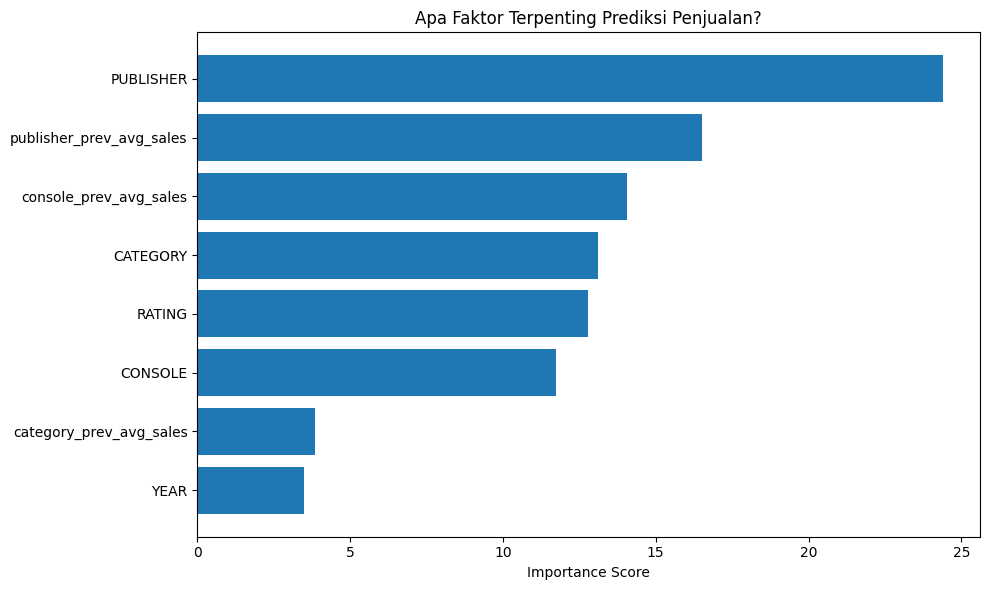

In [31]:
# Visualisasi Feature Importance
feature_imp = model.get_feature_importance()
sorted_idx = np.argsort(feature_imp)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_imp[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
plt.title('Apa Faktor Terpenting Prediksi Penjualan?')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

## BAB 8: Final Deployment (Submission)

Terakhir, kita gunakan model yang sudah dilatih untuk memprediksi data Test.csv yang sebenarnya.

In [32]:
print(">>> Membuat prediksi final untuk Test.csv...")

# Ambil fitur dari data test asli
X_test = df_submission[features]

# Prediksi
final_predictions = model.predict(X_test)

# Buat DataFrame Submission
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'SalesInMillions': final_predictions
})

# Cek hasil
print(submission.head())

>>> Membuat prediksi final untuk Test.csv...
     ID  SalesInMillions
0  4310         1.787440
1  4011         1.969335
2  2185         1.994324
3  1644         2.189787
4   188         1.945213


In [33]:
# Simpan ke CSV
submission.to_csv('PreLaunch_Evolution_Submission.csv', index=False)
print(">>> File 'PreLaunch_Evolution_Submission.csv' siap didownload!")

>>> File 'PreLaunch_Evolution_Submission.csv' siap didownload!
